In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from tqdm import tqdm
import scipy.io
from datetime import datetime
import pickle

### Negative: sublevel
### Postitve: suplevel

In [2]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

## Load persistence information for Cubical Persistence of Positive and Negative regions of SLP-anomaly

In [3]:
# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_posititve_CR.pkl', 'rb') as file:
    loaded_persistences_positive = pickle.load(file)

# Load the dictionary from the pickle file
with open(notebook_directory+'/Data/persistences_negative_CR.pkl', 'rb') as file:
    loaded_persistences_negative = pickle.load(file)

In [4]:
# Function to calculate means of the inner lists
def calculate_sums(nested_list):
    return [np.sum(sublist) for sublist in nested_list]

def find_anomalies_per(df_column):
    # Convert the Series of lists to a 2D numpy array
    # Each row represents a year, each column represents the same day across years
    data_array = np.array(df_column.tolist())

    # Calculate the average for each day across all years
    daily_averages = np.mean(data_array, axis=0)

    # Subtract the daily average from each corresponding day
    anomalies = data_array - daily_averages

    # Convert back to list of lists format
    return [list(year_data) for year_data in anomalies]

In [5]:
# Convert dictionary to DataFrame
per_pos_df = pd.DataFrame(list(loaded_persistences_positive.items()), columns=['Year', 'Persistences'])
# Apply the function to each element in the 'Persistences' column to create the new 'Means' column
per_pos_df['total_persistence'] = per_pos_df['Persistences'].apply(calculate_sums)
per_pos_df["anomaly_total_per"] = find_anomalies_per(per_pos_df.total_persistence)

In [6]:
# Convert dictionary to DataFrame
per_neg_df = pd.DataFrame(list(loaded_persistences_negative.items()), columns=['Year', 'Persistences'])
# Apply the function to each element in the 'Persistences' column to create the new 'Means' column
per_neg_df['total_persistence'] = per_neg_df['Persistences'].apply(calculate_sums)
per_neg_df["anomaly_total_per"] = find_anomalies_per(per_neg_df.total_persistence)

### Slicing df to match time for other climate indices

In [7]:
num_of_years = 2022 - 1950 + 1
num_of_days = num_of_years * 365
num_of_years, num_of_days

(73, 26645)

In [8]:
per_pos_df = per_pos_df[2:75]
per_neg_df = per_neg_df[2:75]
pos_total_per_list = np.array(per_pos_df.total_persistence.to_list()).flatten()
neg_total_per_list = np.array(per_neg_df.total_persistence.to_list()).flatten()
pos_anomaly_total_per_list = np.array(per_pos_df.anomaly_total_per.to_list()).flatten()
neg_anomaly_total_per_list = np.array(per_neg_df.anomaly_total_per.to_list()).flatten()

## Loading climate indices

### Daily climate indices

In [9]:
# entry from 1 Jan 1950 to 31 Dec 2024
mat_indices = scipy.io.loadmat(notebook_directory+'/Data/Several_Atmospheric_Indices_since1950.mat')

In [10]:
# Extract the arrays from mat_indices
dates = mat_indices['Dates_all'][0][:num_of_days]  # Remove the extra dimension
amo = mat_indices['AMO_daily'][0][:num_of_days] 
ea = mat_indices['EA_daily_detrend'][0][:num_of_days] 
enso = mat_indices['ENSO_daily'][0][:num_of_days] 
nao = mat_indices['NAO_daily'][0][:num_of_days] 
pdo = mat_indices['PDO_daily'][0][:num_of_days] 
scand = mat_indices['SCAND_daily'][0][:num_of_days] 

In [11]:
# Convert date integers to datetime objects
datetime_dates = []
for date_int in dates:
    year = int(date_int // 10000)
    month = int((date_int % 10000) // 100)
    day = int(date_int % 100)
    datetime_dates.append(datetime(year, month, day))

In [12]:
# Create DataFrame
indices_df_daily = pd.DataFrame({
    'Date': datetime_dates,
    'AMO': amo,
    'EA': ea,
    'ENSO': enso,
    'NAO': nao,
    'PDO': pdo,
    'SCAND': scand,
    'TPASUP': pos_anomaly_total_per_list,
    'TPASUB': neg_anomaly_total_per_list,
    'TPSUP': pos_total_per_list,
    'TPSUB': neg_total_per_list,

})

# Set the 'Date' column as the index
indices_df_daily.set_index('Date', inplace=True)

### Average monthly values

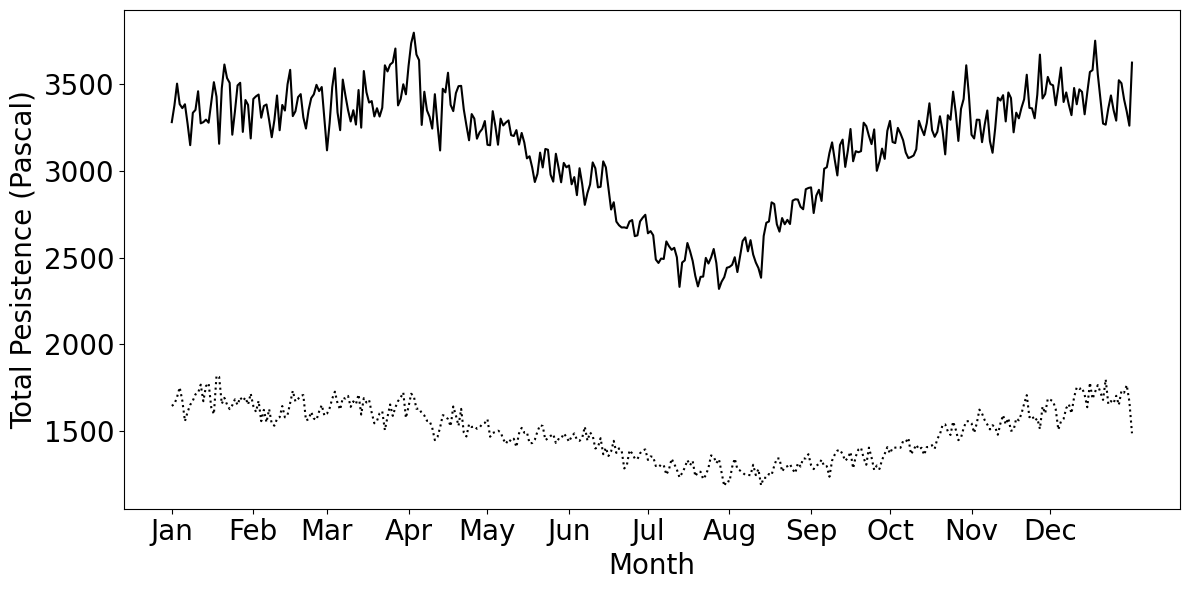

In [20]:
# Set font size parameters here
fs = 20
axis_label_fontsize = fs
tick_label_fontsize = fs
legend_fontsize = fs

# Extract day of year (ignoring year)
indices_df_daily['day_of_year'] = indices_df_daily.index.dayofyear

# Group by day of year and calculate mean
tpsup_avg = indices_df_daily.groupby('day_of_year')['TPSUP'].mean()
tpsub_avg = indices_df_daily.groupby('day_of_year')['TPSUB'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(tpsup_avg.index, tpsup_avg.values, label='TPDSUP Average', color='black', linestyle='-')
plt.plot(tpsub_avg.index, tpsub_avg.values, label='TPDSUB Average', color='black', linestyle=':')

# Add labels and title with custom font sizes
plt.xlabel('Month', fontsize=axis_label_fontsize)
plt.ylabel('Total Pesistence (Pascal)', fontsize=axis_label_fontsize)
#plt.legend(fontsize=legend_fontsize)

# Set tick font sizes
plt.xticks(fontsize=tick_label_fontsize)
plt.yticks(fontsize=tick_label_fontsize)

# Add tick marks for months (approximately)
month_positions = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_positions, month_labels, fontsize=tick_label_fontsize)


plt.tight_layout()
plt.savefig("figures/TP_average.png", dpi=600, bbox_inches='tight')
plt.show()

### Monthly climate indices

In [46]:
# Resample to monthly frequency
monthly_df = indices_df_daily[['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND','TPASUP', 'TPASUB']].resample('MS').mean()

## Analysis of Monthly climate indices

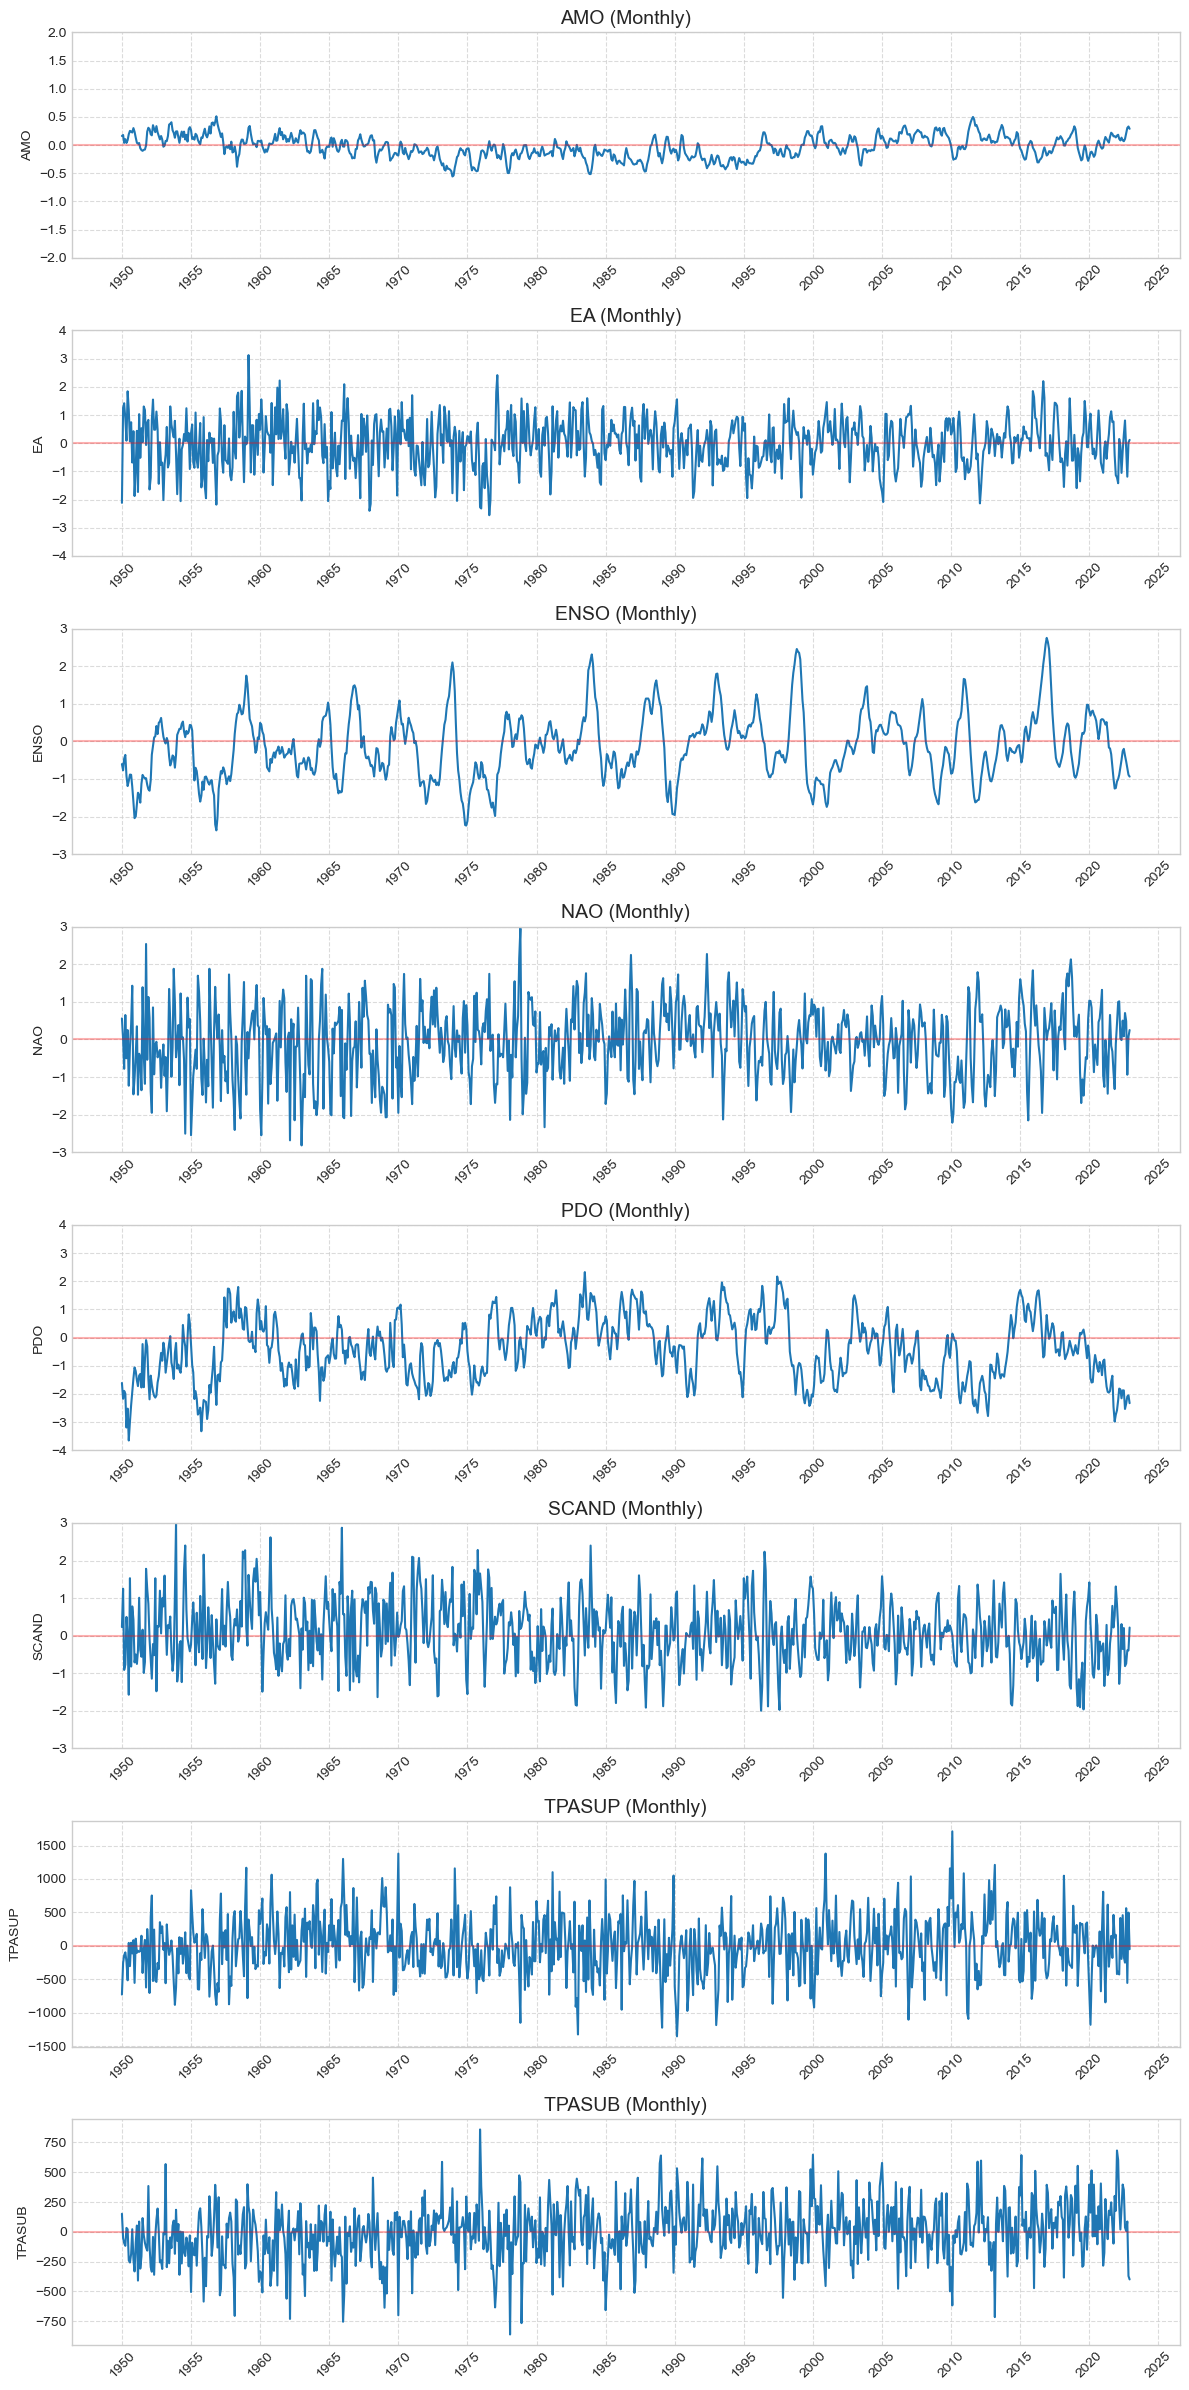

In [47]:
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting each column of the monthly dataframe
fig, axs = plt.subplots(8, 1, figsize=(12, 24))
columns = monthly_df.columns  # All columns to plot

for i, col in enumerate(columns):
    # Plot the data
    axs[i].plot(monthly_df.index, monthly_df[col], linewidth=1.5)
    
    # Set title and labels
    axs[i].set_title(f'{col} (Monthly)', fontsize=14)
    axs[i].set_ylabel(col)
    
    # Format x-axis to show years nicely
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[i].xaxis.set_major_locator(mdates.YearLocator(5))  # Show every 5 years
    
    # Rotate date labels for better readability
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
    
    # Add grid for better readability
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at y=0 for reference
    axs[i].axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Improve y-axis scale to better show data variations
    if col in ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']:
        # For climate indices, set reasonable y-limits based on typical ranges
        y_max = max(2, np.ceil(monthly_df[col].abs().max()))
        axs[i].set_ylim(-y_max, y_max)
    else:
        # For anomaly columns, automatic scaling looks good
        pass

plt.tight_layout()
plt.show()


Detailed Statistical Analysis:

===== TPASUP =====
AMO: r = 0.008, p-value = 0.80178 
EA: r = 0.109, p-value = 0.00121 **
ENSO: r = -0.025, p-value = 0.46164 
NAO: r = -0.573, p-value = 0.00000 ***
PDO: r = 0.107, p-value = 0.00153 **
SCAND: r = -0.035, p-value = 0.30139 


===== TPASUB =====
AMO: r = -0.034, p-value = 0.31499 
EA: r = -0.162, p-value = 0.00000 ***
ENSO: r = 0.073, p-value = 0.03104 *
NAO: r = 0.516, p-value = 0.00000 ***
PDO: r = -0.057, p-value = 0.09240 
SCAND: r = -0.005, p-value = 0.89233 




<Figure size 1200x800 with 0 Axes>

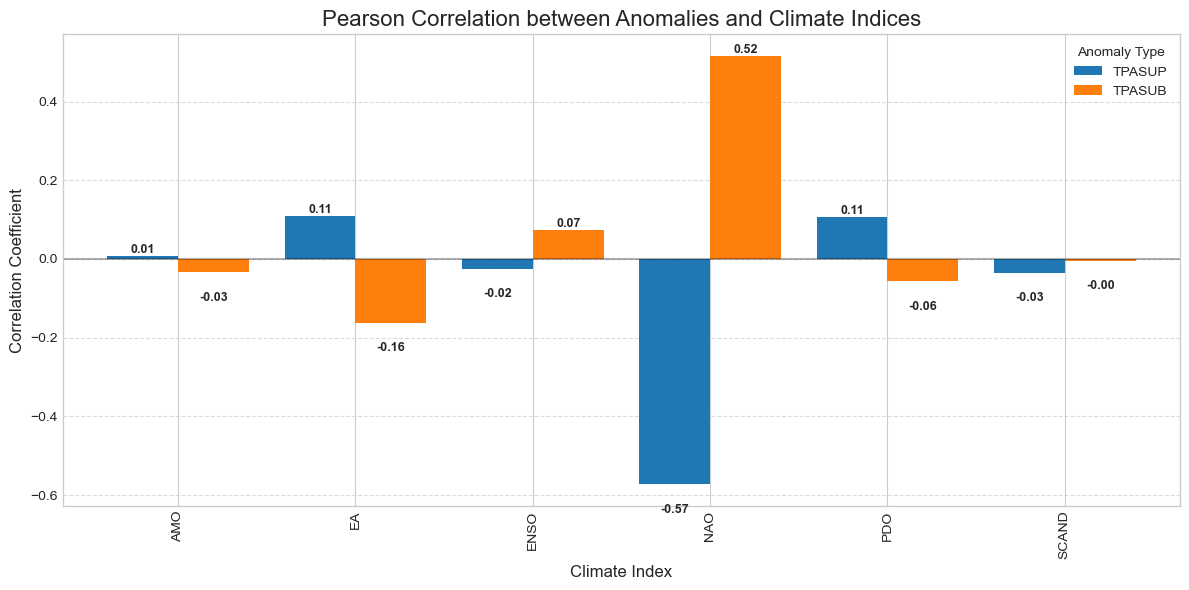

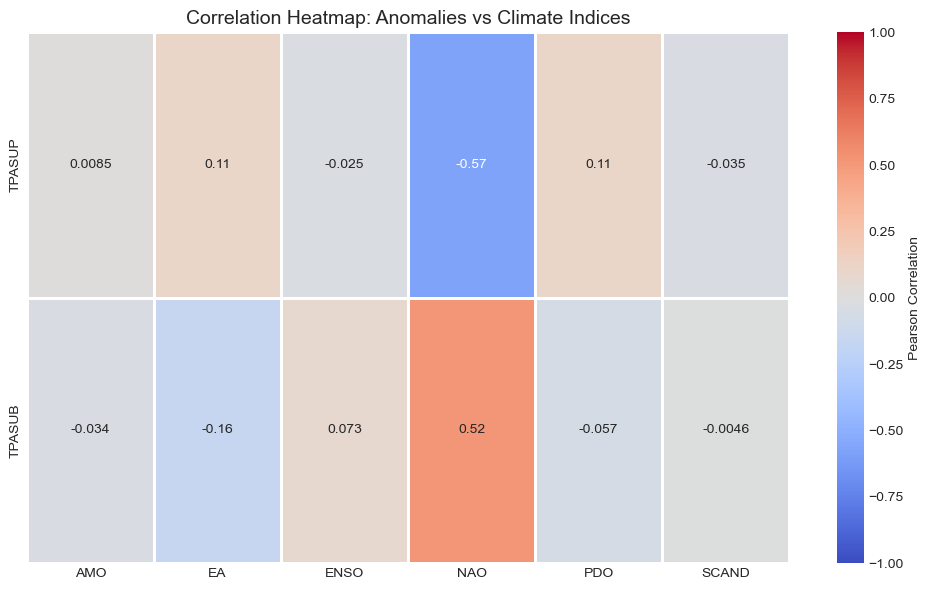

In [53]:
import seaborn as sns

# Calculate the correlation coefficients
correlation_matrix = monthly_df.corr(method='pearson')

# Extract correlations of anomalies with climate indices
pos_anomaly_correlations = correlation_matrix.loc['TPASUP', ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']]
neg_anomaly_correlations = correlation_matrix.loc['TPASUB', ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']]

# Create a DataFrame for easier plotting
correlation_df = pd.DataFrame({
    'TPASUP': pos_anomaly_correlations,
    'TPASUB': neg_anomaly_correlations
})

# Plot the correlations
plt.figure(figsize=(12, 8))

# Create bar plot
ax = correlation_df.plot(kind='bar', width=0.8, figsize=(12, 6))
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add correlation values on top of the bars
for i, (index, row) in enumerate(correlation_df.iterrows()):
    for j, col in enumerate(['TPASUP', 'TPASUB']):
        value = row[col]
        height = value if value > 0 else value - 0.05
        ax.text(i - 0.2 + j*0.4, height, f'{value:.2f}', 
                ha='center', va='bottom' if value > 0 else 'top', 
                fontweight='bold', fontsize=9)

plt.title('Pearson Correlation between Anomalies and Climate Indices', fontsize=16)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Climate Index', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Anomaly Type')
plt.tight_layout()

# Create a heatmap for a different visualization
plt.figure(figsize=(10, 6))
subset_corr = correlation_matrix.loc[['TPASUP', 'TPASUB'], 
                                     ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']]

sns.heatmap(subset_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            linewidths=1, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Correlation Heatmap: Anomalies vs Climate Indices', fontsize=14)
plt.tight_layout()

# Detailed statistical analysis
print("\nDetailed Statistical Analysis:\n")
for anomaly in ['TPASUP', 'TPASUB']:
    print(f"===== {anomaly} =====")
    for climate_index in ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']:
        corr = correlation_matrix.loc[anomaly, climate_index]
        
        # Calculate p-value for the correlation
        from scipy.stats import pearsonr
        correlation, p_value = pearsonr(monthly_df[anomaly].values, monthly_df[climate_index].values)
        
        significance = ""
        if p_value < 0.001:
            significance = "***"  # Highly significant
        elif p_value < 0.01:
            significance = "**"   # Very significant
        elif p_value < 0.05:
            significance = "*"    # Significant
            
        print(f"{climate_index}: r = {corr:.3f}, p-value = {p_value:.5f} {significance}")
    print("\n")

plt.show()

# Normal Distribution

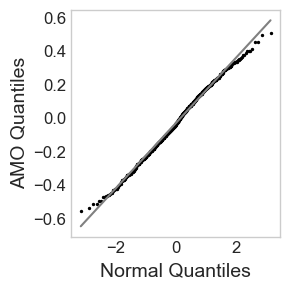

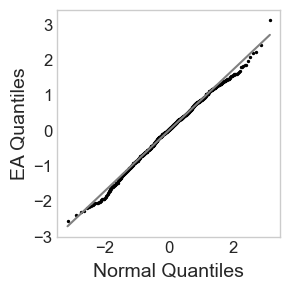

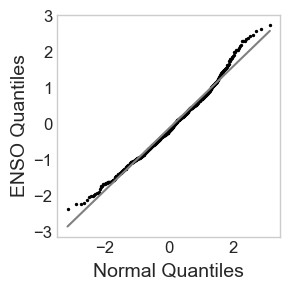

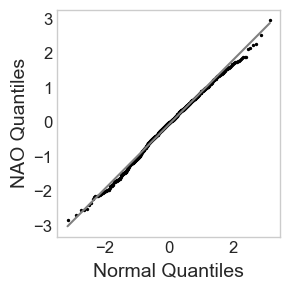

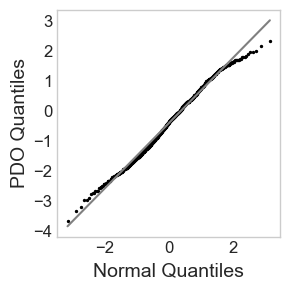

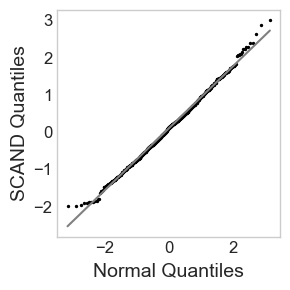

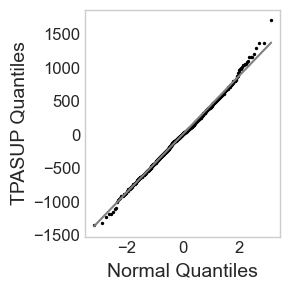

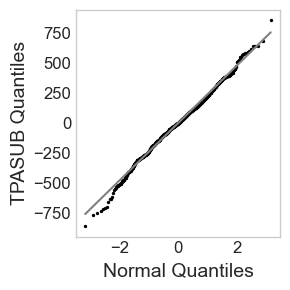

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import os

# Create figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# Define variables to test
variables = ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND', 
             'TPASUP', 'TPASUB']

# Set font sizes
axis_label_size = 14
tick_label_size = 12

# Set DPI for high resolution images
dpi = 600

# Create individual Q-Q plots for each variable
for var in variables:
    plt.figure(figsize=(3, 3))
    
    # Get the data for Q-Q plot
    res = stats.probplot(monthly_df[var], dist="norm", fit=False)
    
    # Create custom Q-Q plot with smaller points and black/grey colors
    plt.scatter(res[0], res[1], s=2, color='black', alpha=1)  # Smaller points (s=10) and black color
    
    # Calculate and plot the line
    slope, intercept, r_value, p_value, std_err = stats.linregress(res[0], res[1])
    line_x = res[0]
    line_y = intercept + slope * line_x
    plt.plot(line_x, line_y, color='gray')  # Grey line
    
    # Remove grid lines
    plt.grid(False)
    
    # No title
    plt.title('')
    
    # Set axis labels
    plt.xlabel('Normal Quantiles', fontsize=axis_label_size)
    plt.ylabel(f'{var} Quantiles', fontsize=axis_label_size)
    
    # Keep all spines (the box)
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    
    # Set tick label size
    plt.xticks(fontsize=tick_label_size)
    plt.yticks(fontsize=tick_label_size)
    
    plt.tight_layout()
    
    # Save figure with high resolution
    filename = f'figures/qq_plot_{var}.png'
    #plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Lagged Coorelation

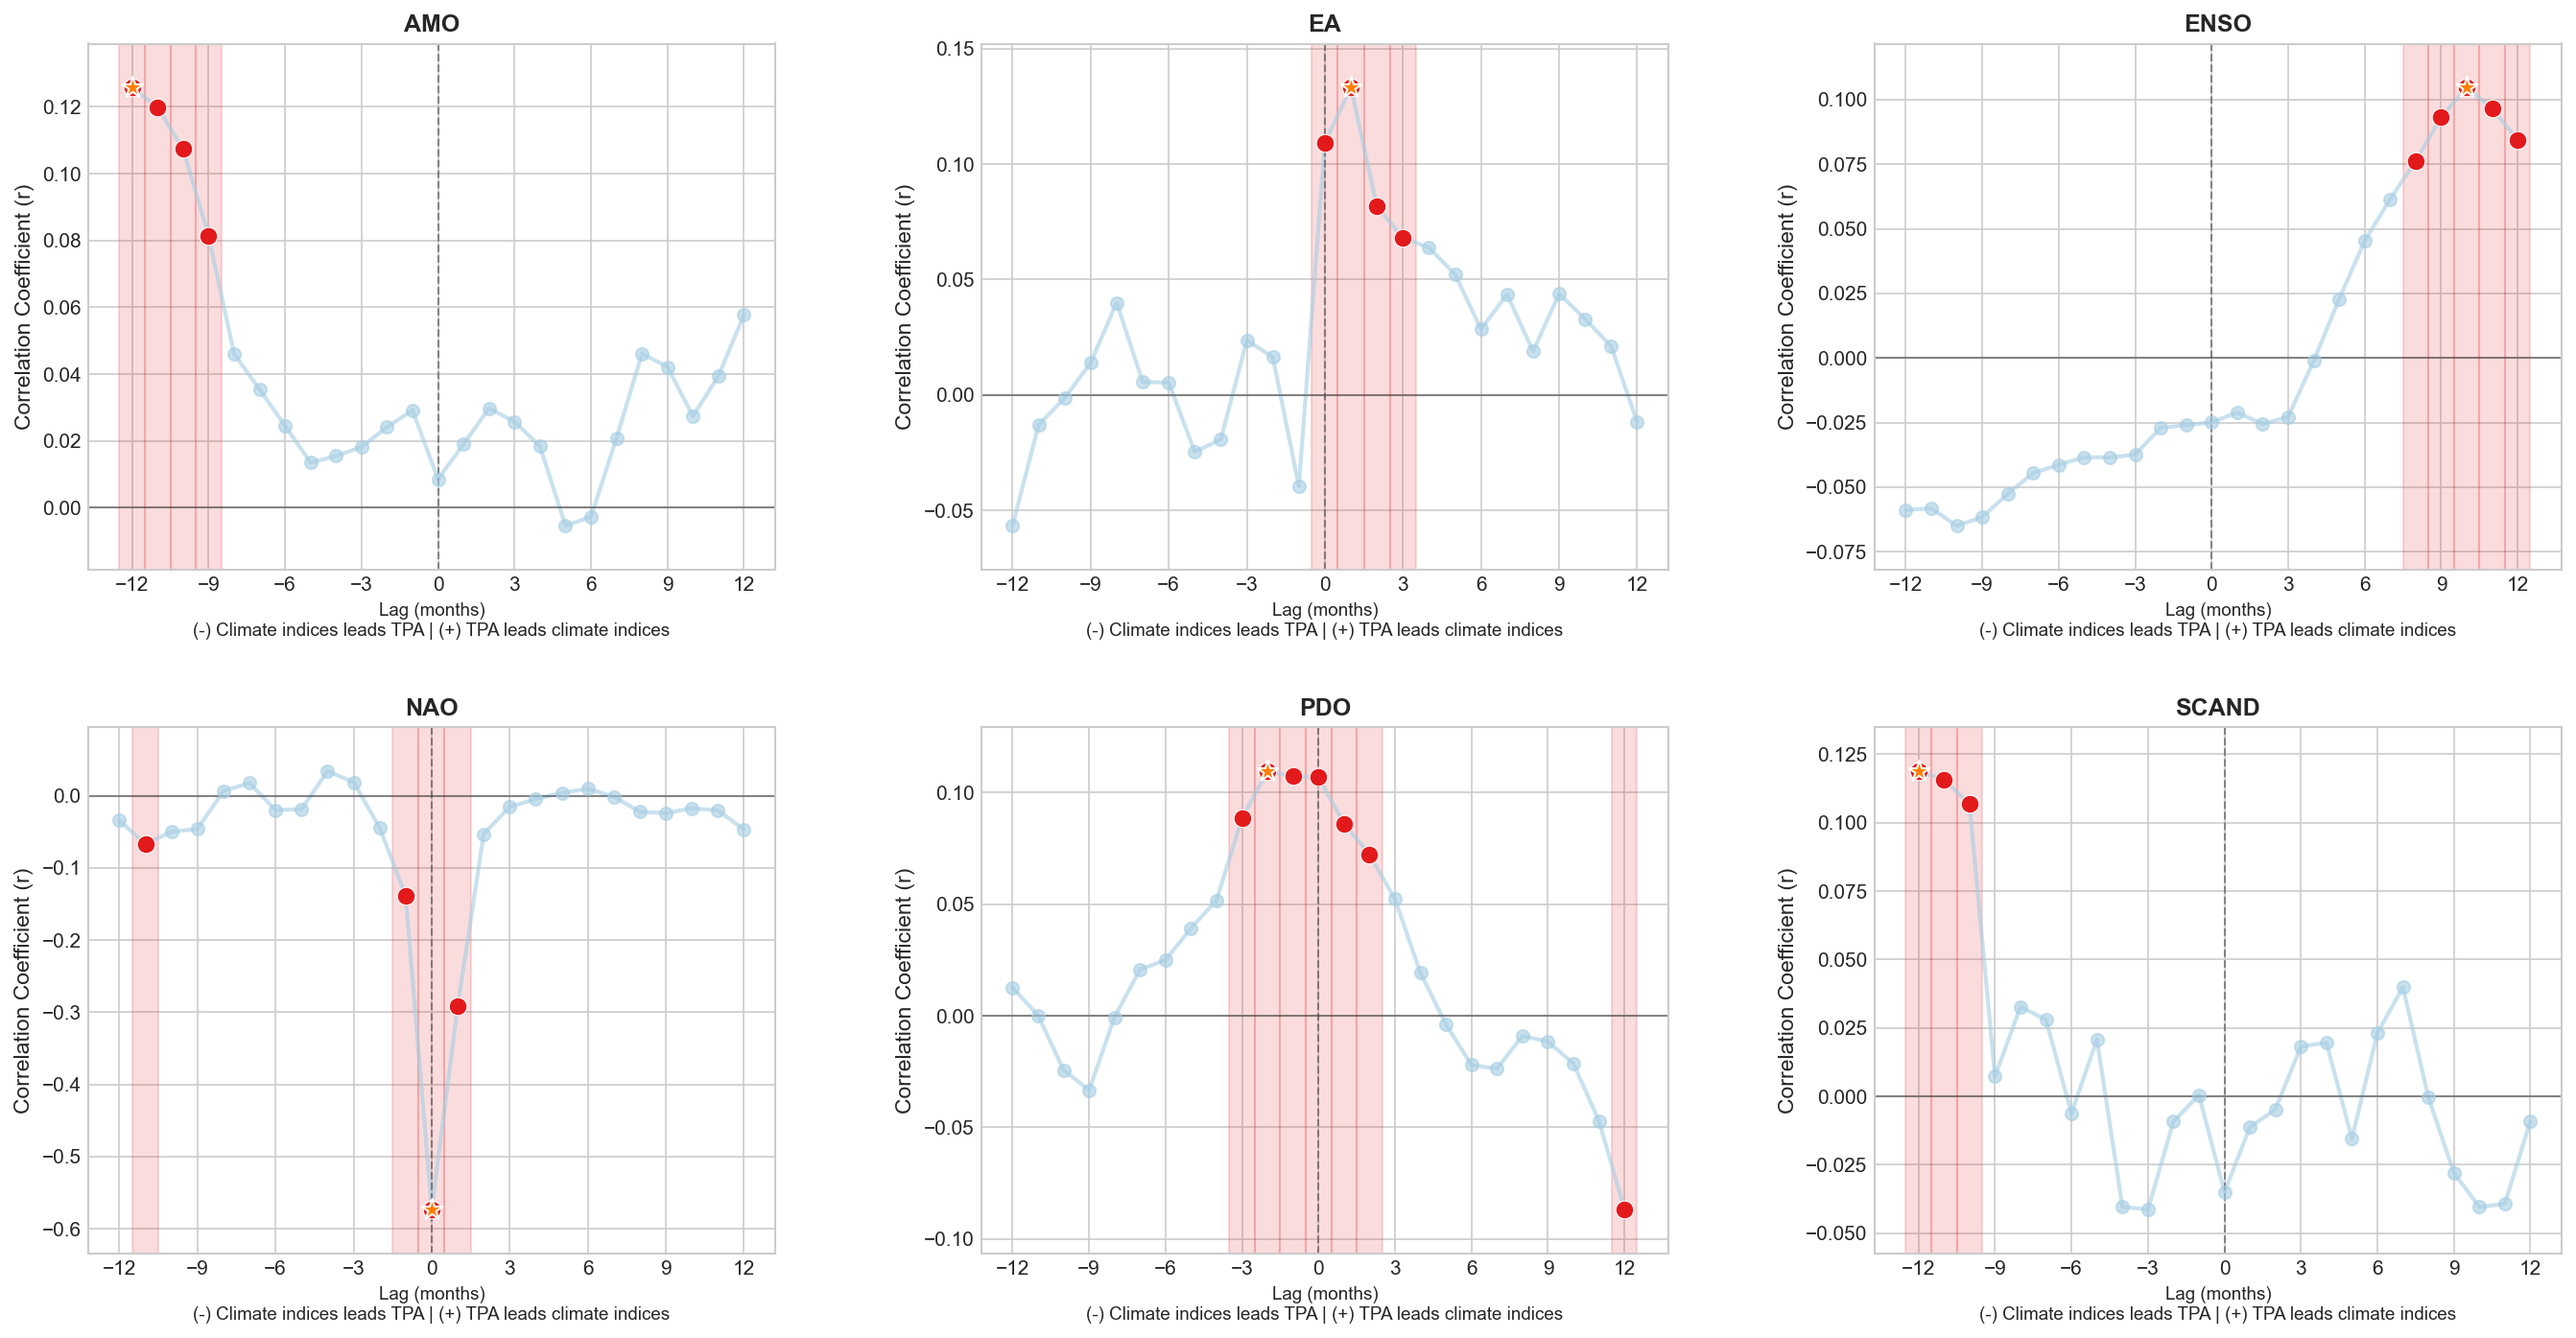

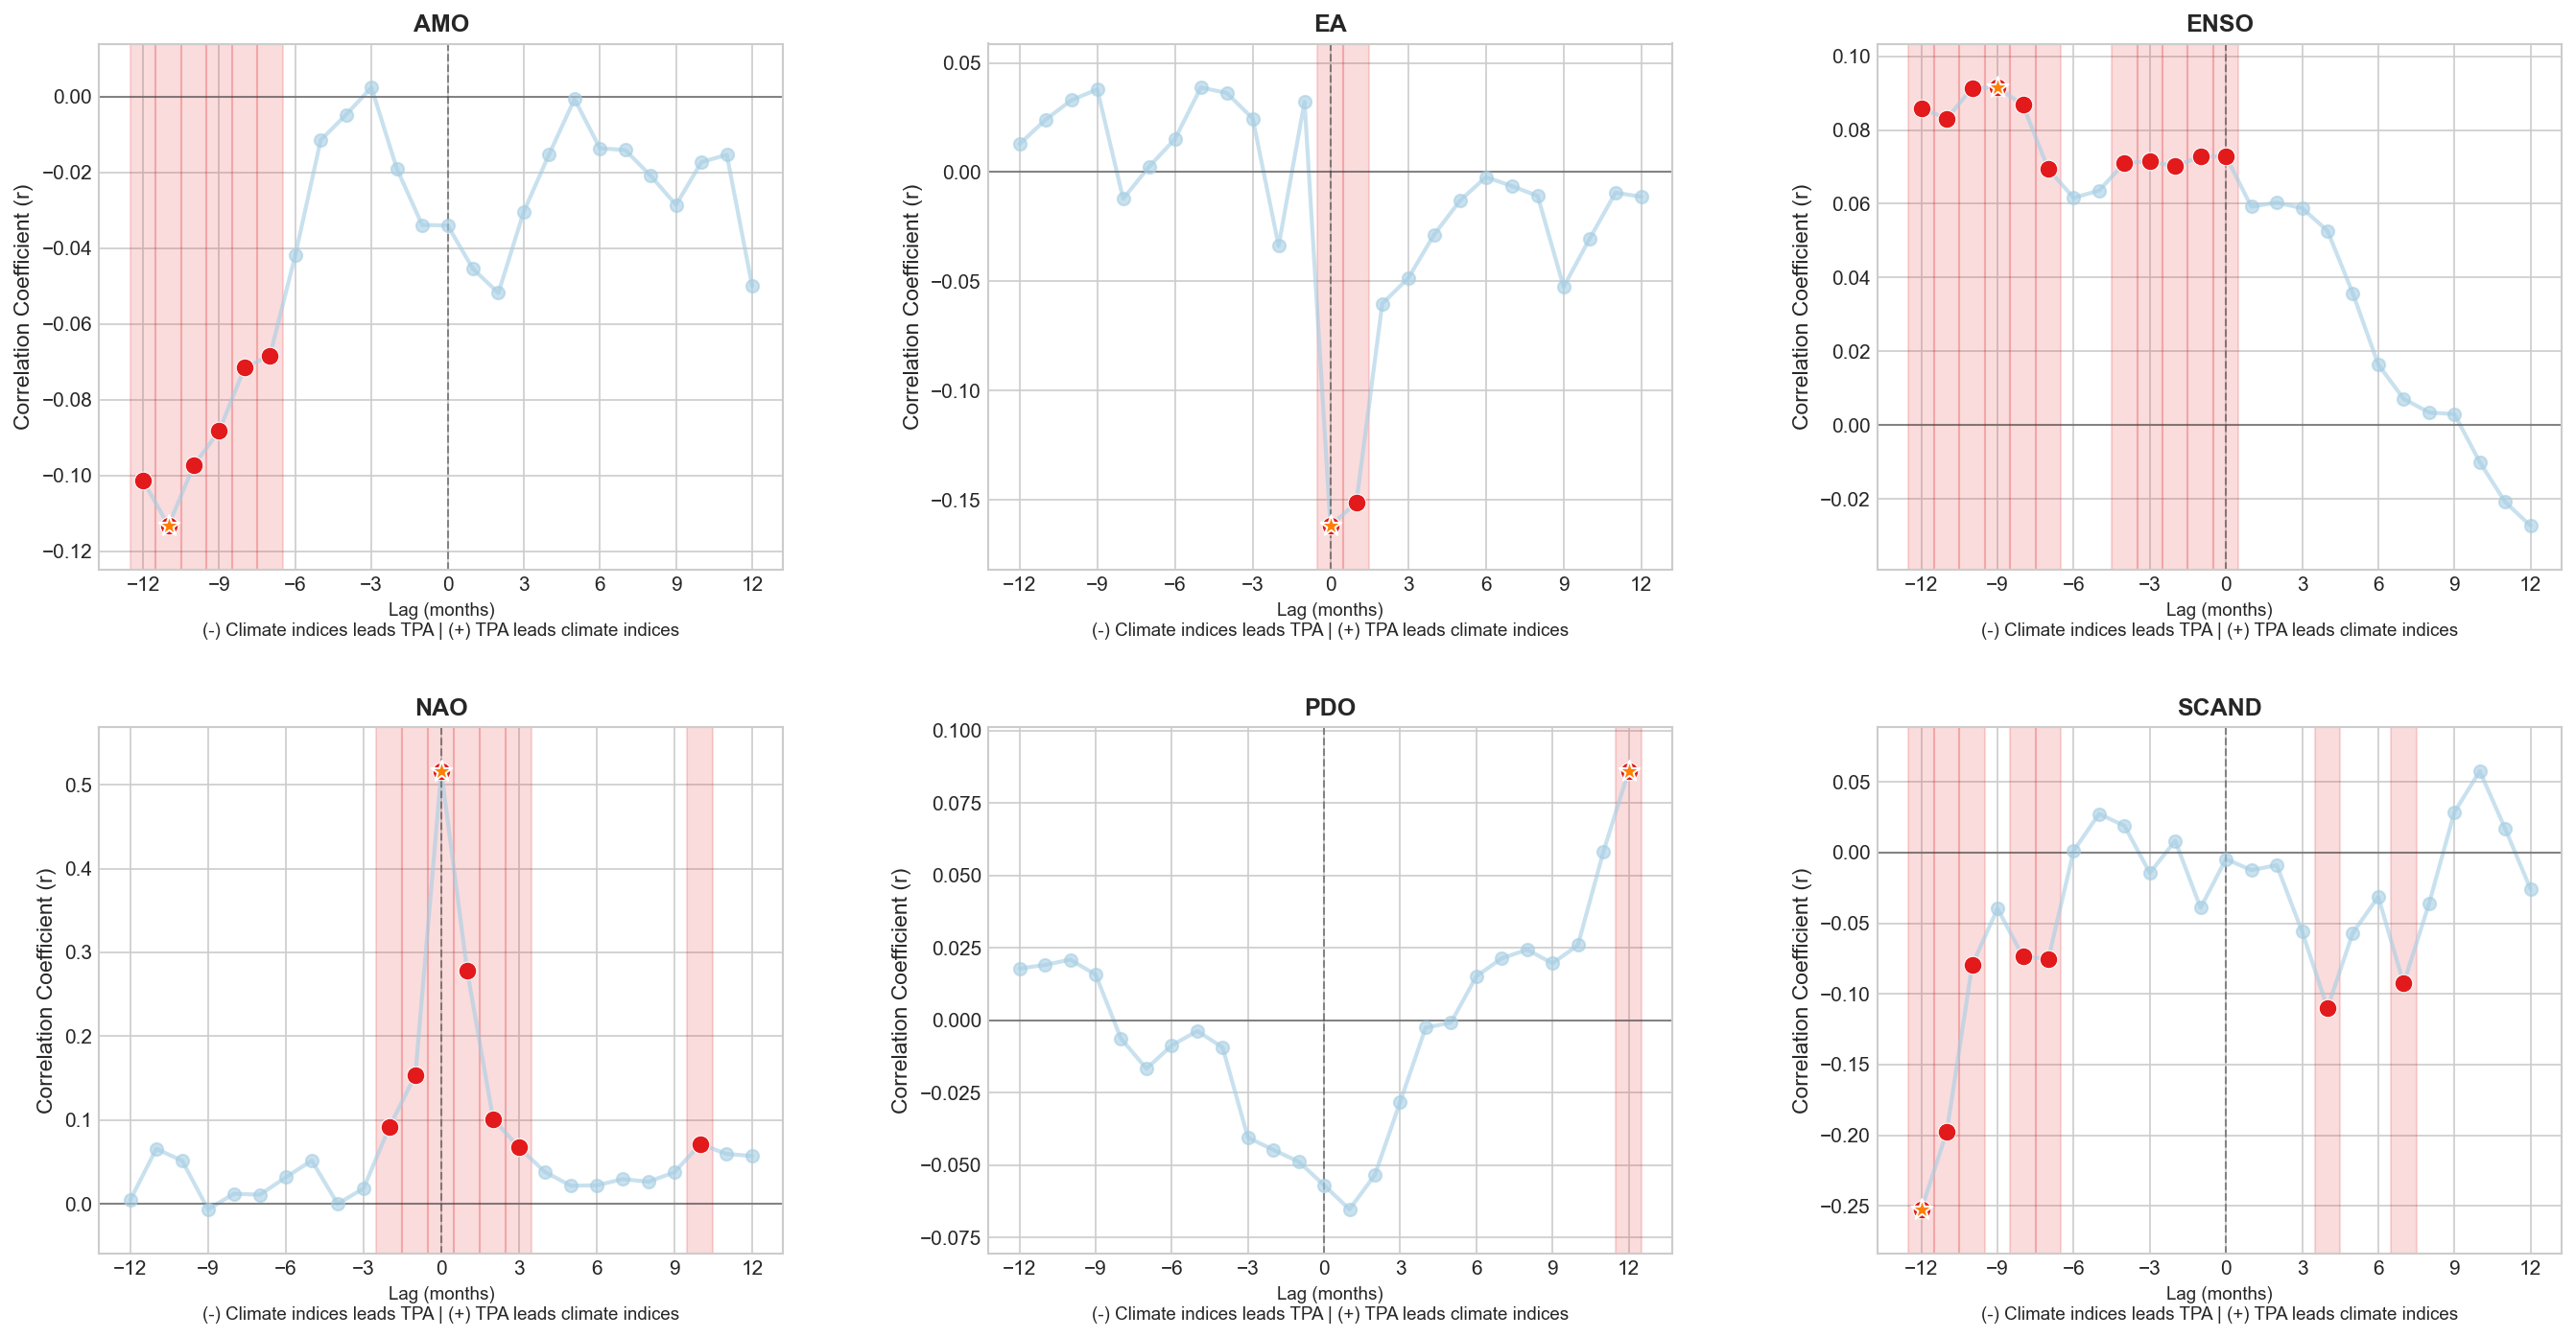

In [88]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Set the style for more professional plots
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Define function for calculating lagged correlations (same as before)
def lagged_correlation(df, target_cols, climate_indices, lags=range(-12, 13)):
    """
    Calculate lagged correlations between target columns and climate indices
    
    Parameters:
    - df: DataFrame containing the data
    - target_cols: List of target column names (anomaly metrics)
    - climate_indices: List of climate index column names
    - lags: Range of lags to analyze (negative = climate leads anomaly, positive = anomaly leads climate)
    
    Returns:
    - DataFrame with correlation values
    """
    results = {}
    
    for target in target_cols:
        target_results = {}
        
        for index_name in climate_indices:
            lag_corrs = []
            lag_pvals = []
            
            for lag in lags:
                if lag < 0:
                    # Climate index leads anomaly
                    tmp_df = pd.DataFrame({
                        'target': df[target].iloc[abs(lag):].values,
                        'index': df[index_name].iloc[:len(df)-abs(lag)].values
                    }).dropna()
                elif lag > 0:
                    # Anomaly leads climate index
                    tmp_df = pd.DataFrame({
                        'target': df[target].iloc[:len(df)-lag].values,
                        'index': df[index_name].iloc[lag:].values
                    }).dropna()
                else:
                    # No lag (contemporaneous)
                    tmp_df = pd.DataFrame({
                        'target': df[target].values,
                        'index': df[index_name].values
                    }).dropna()
                
                if len(tmp_df) > 10:  # Ensure enough data points
                    corr, p_val = pearsonr(tmp_df['target'], tmp_df['index'])
                    lag_corrs.append(corr)
                    lag_pvals.append(p_val)
                else:
                    lag_corrs.append(np.nan)
                    lag_pvals.append(np.nan)
            
            target_results[f"{index_name}_corr"] = lag_corrs
            target_results[f"{index_name}_pval"] = lag_pvals
        
        results[target] = pd.DataFrame(target_results, index=lags)
    
    return results

# Define target columns and climate indices
targets = ['TPASUP', 'TPASUB']
indices = ['AMO', 'EA', 'ENSO', 'NAO', 'PDO', 'SCAND']

# Calculate lagged correlations
lag_range = range(-12, 13)  # -12 to +12 months
lagged_results = lagged_correlation(monthly_df, targets, indices, lag_range)

# Define human-readable names for the targets
target_labels = {
    'TPASUP': 'TPASUP',
    'TPASUB': 'TPASUB'
}

# Define custom color schemes
colors = {
    'non_significant': '#a6cee3',  # Light blue
    'significant': '#e31a1c',      # Bright red
    'highlight': '#ff7f00',        # Orange
    'grid': '#cccccc',             # Light gray
    'zero_line': '#333333',        # Dark gray
}

## Plot lagged correlations with improved styling
for target in targets:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=150)
    axes = axes.flatten()
    
    for i, index_name in enumerate(indices):
        corr_col = f"{index_name}_corr"
        pval_col = f"{index_name}_pval"
        results_df = lagged_results[target]
        
        ax = axes[i]
        
        # Get significant correlations
        significant = results_df[pval_col] < 0.05
        
        # Plot all correlations
        ax.plot(results_df.index, results_df[corr_col], '-', alpha=0.6, 
                color=colors['non_significant'], linewidth=2)
        ax.scatter(results_df.index, results_df[corr_col], alpha=0.6, 
                  color=colors['non_significant'], s=40, zorder=5)
        
        # Highlight significant correlations
        if any(significant):
            ax.scatter(results_df.index[significant], results_df[corr_col][significant], 
                      color=colors['significant'], s=80, zorder=10, 
                      label='p < 0.05', edgecolor='white', linewidth=0.5)
        
        # Add horizontal line at zero
        ax.axhline(y=0, color=colors['zero_line'], linestyle='-', alpha=0.5, linewidth=1)
        
        # Add vertical line at zero lag
        ax.axvline(x=0, color=colors['zero_line'], linestyle='--', alpha=0.5, linewidth=1)
        
        # Shade areas with significant correlations
        for lag in results_df.index[significant]:
            ax.axvspan(lag-0.5, lag+0.5, alpha=0.15, color=colors['significant'], zorder=1)

        # Label maximum absolute correlation
        if not results_df[corr_col].isna().all():
            max_corr_idx = results_df[corr_col].abs().idxmax()
            max_corr = results_df[corr_col].loc[max_corr_idx]
            max_pval = results_df[pval_col].loc[max_corr_idx]
            
            # Highlight the max correlation point
            ax.scatter([max_corr_idx], [max_corr], color=colors['highlight'], 
                      s=120, zorder=15, marker='*', edgecolor='white', linewidth=1)
        
        # Add descriptive title and labels
        lag_direction = "(-) Climate indices leads TPA | (+) TPA leads climate indices"
        ax.set_title(f'{index_name}', fontweight='bold')
        ax.set_xlabel(f'Lag (months)\n{lag_direction}', fontsize=9)
        ax.set_ylabel('Correlation Coefficient (r)')
        
        # Set y-axis limits with a bit of padding
        corr_range = results_df[corr_col].max() - results_df[corr_col].min()
        y_min = max(-1, results_df[corr_col].min() - 0.1 * corr_range)
        y_max = min(1, results_df[corr_col].max() + 0.1 * corr_range)
        ax.set_ylim(y_min, y_max)
        
        # X-axis ticks
        ax.set_xticks(list(range(min(lag_range), max(lag_range)+1, 3)))

    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    plt.show()

In [108]:
import os

# Create directory if it doesn't exist
save_dir = r"figures/delay_corr"
os.makedirs(save_dir, exist_ok=True)

# Define font sizes for consistency
font_sizes = {
    'title': 14,
    'axis_label': 12,
    'tick_label': 10,
    'annotation': 10,
    'legend': 10
}

# Define updated color scheme with black and gray
colors = {
    'non_significant': '#888888',  # Medium gray for non-significant points
    'significant': '#000000',      # Black for significant points
    'highlight': '#333333',        # Dark gray for highlight points
    'shade_area': '#999999',       # Light gray for shaded areas
    'zero_line': '#444444',        # Darker gray for zero lines
}

# Plot and save individual plots for each climate index and target
for target in targets:
    for index_name in indices:
        # Create a new figure for each climate index
        fig, ax = plt.figure(figsize=(4, 3), dpi=600), plt.gca()
        
        corr_col = f"{index_name}_corr"
        pval_col = f"{index_name}_pval"
        results_df = lagged_results[target]
        
        # Turn off grid lines
        ax.grid(False)
        
        # Get significant correlations
        significant = results_df[pval_col] < 0.05
        
        # Plot all correlations
        ax.plot(results_df.index, results_df[corr_col], '-', alpha=0.7, 
                color=colors['non_significant'], linewidth=1.5)
        ax.scatter(results_df.index, results_df[corr_col], alpha=0.7, 
                  color=colors['non_significant'], s=40, zorder=5)
        
        # Highlight significant correlations
        if any(significant):
            ax.scatter(results_df.index[significant], results_df[corr_col][significant], 
                      color=colors['significant'], s=70, zorder=10, 
                      label='p < 0.05', edgecolor='white', linewidth=0.5)
        
        # Add horizontal line at zero
        ax.axhline(y=0, color=colors['zero_line'], linestyle='-', alpha=0.5, linewidth=1)
        
        # Add vertical line at zero lag
        ax.axvline(x=0, color=colors['zero_line'], linestyle='--', alpha=0.5, linewidth=1)
        
        # Shade areas with significant correlations - no outline
        for lag in results_df.index[significant]:
            ax.axvspan(lag-0.5, lag+0.5, alpha=0.25, color=colors['shade_area'], 
                      zorder=1, linewidth=0)

        # Label maximum absolute correlation
        if not results_df[corr_col].isna().all():
            max_corr_idx = results_df[corr_col].abs().idxmax()
            max_corr = results_df[corr_col].loc[max_corr_idx]
            max_pval = results_df[pval_col].loc[max_corr_idx]
            
            # Highlight the max correlation point
            ax.scatter([max_corr_idx], [max_corr], color=colors['highlight'], 
                      s=120, zorder=15, marker='*', edgecolor='white', linewidth=1)
        
        # Set fonts with specified sizes
        #ax.set_title(f'{index_name}', fontsize=font_sizes['title'])
        ax.set_xlabel('Lag (months)', fontsize=font_sizes['axis_label'])
        ax.set_ylabel('Correlation Coefficient (r)', fontsize=font_sizes['axis_label'])
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=font_sizes['tick_label'])
        
        # Set y-axis limits with a bit of padding
        corr_range = results_df[corr_col].max() - results_df[corr_col].min()
        y_min = max(-1, results_df[corr_col].min() - 0.1 * corr_range)
        y_max = min(1, results_df[corr_col].max() + 0.1 * corr_range)
        ax.set_ylim(y_min, y_max)
        
        # X-axis ticks
        ax.set_xticks(list(range(min(lag_range), max(lag_range)+1, 3)))
        
        # Tight layout for better appearance
        plt.tight_layout()
        
        # Save the figure with descriptive filename
        filename = f"{target}_{index_name}_lag_correlation.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=600, bbox_inches='tight') 
        plt.close()

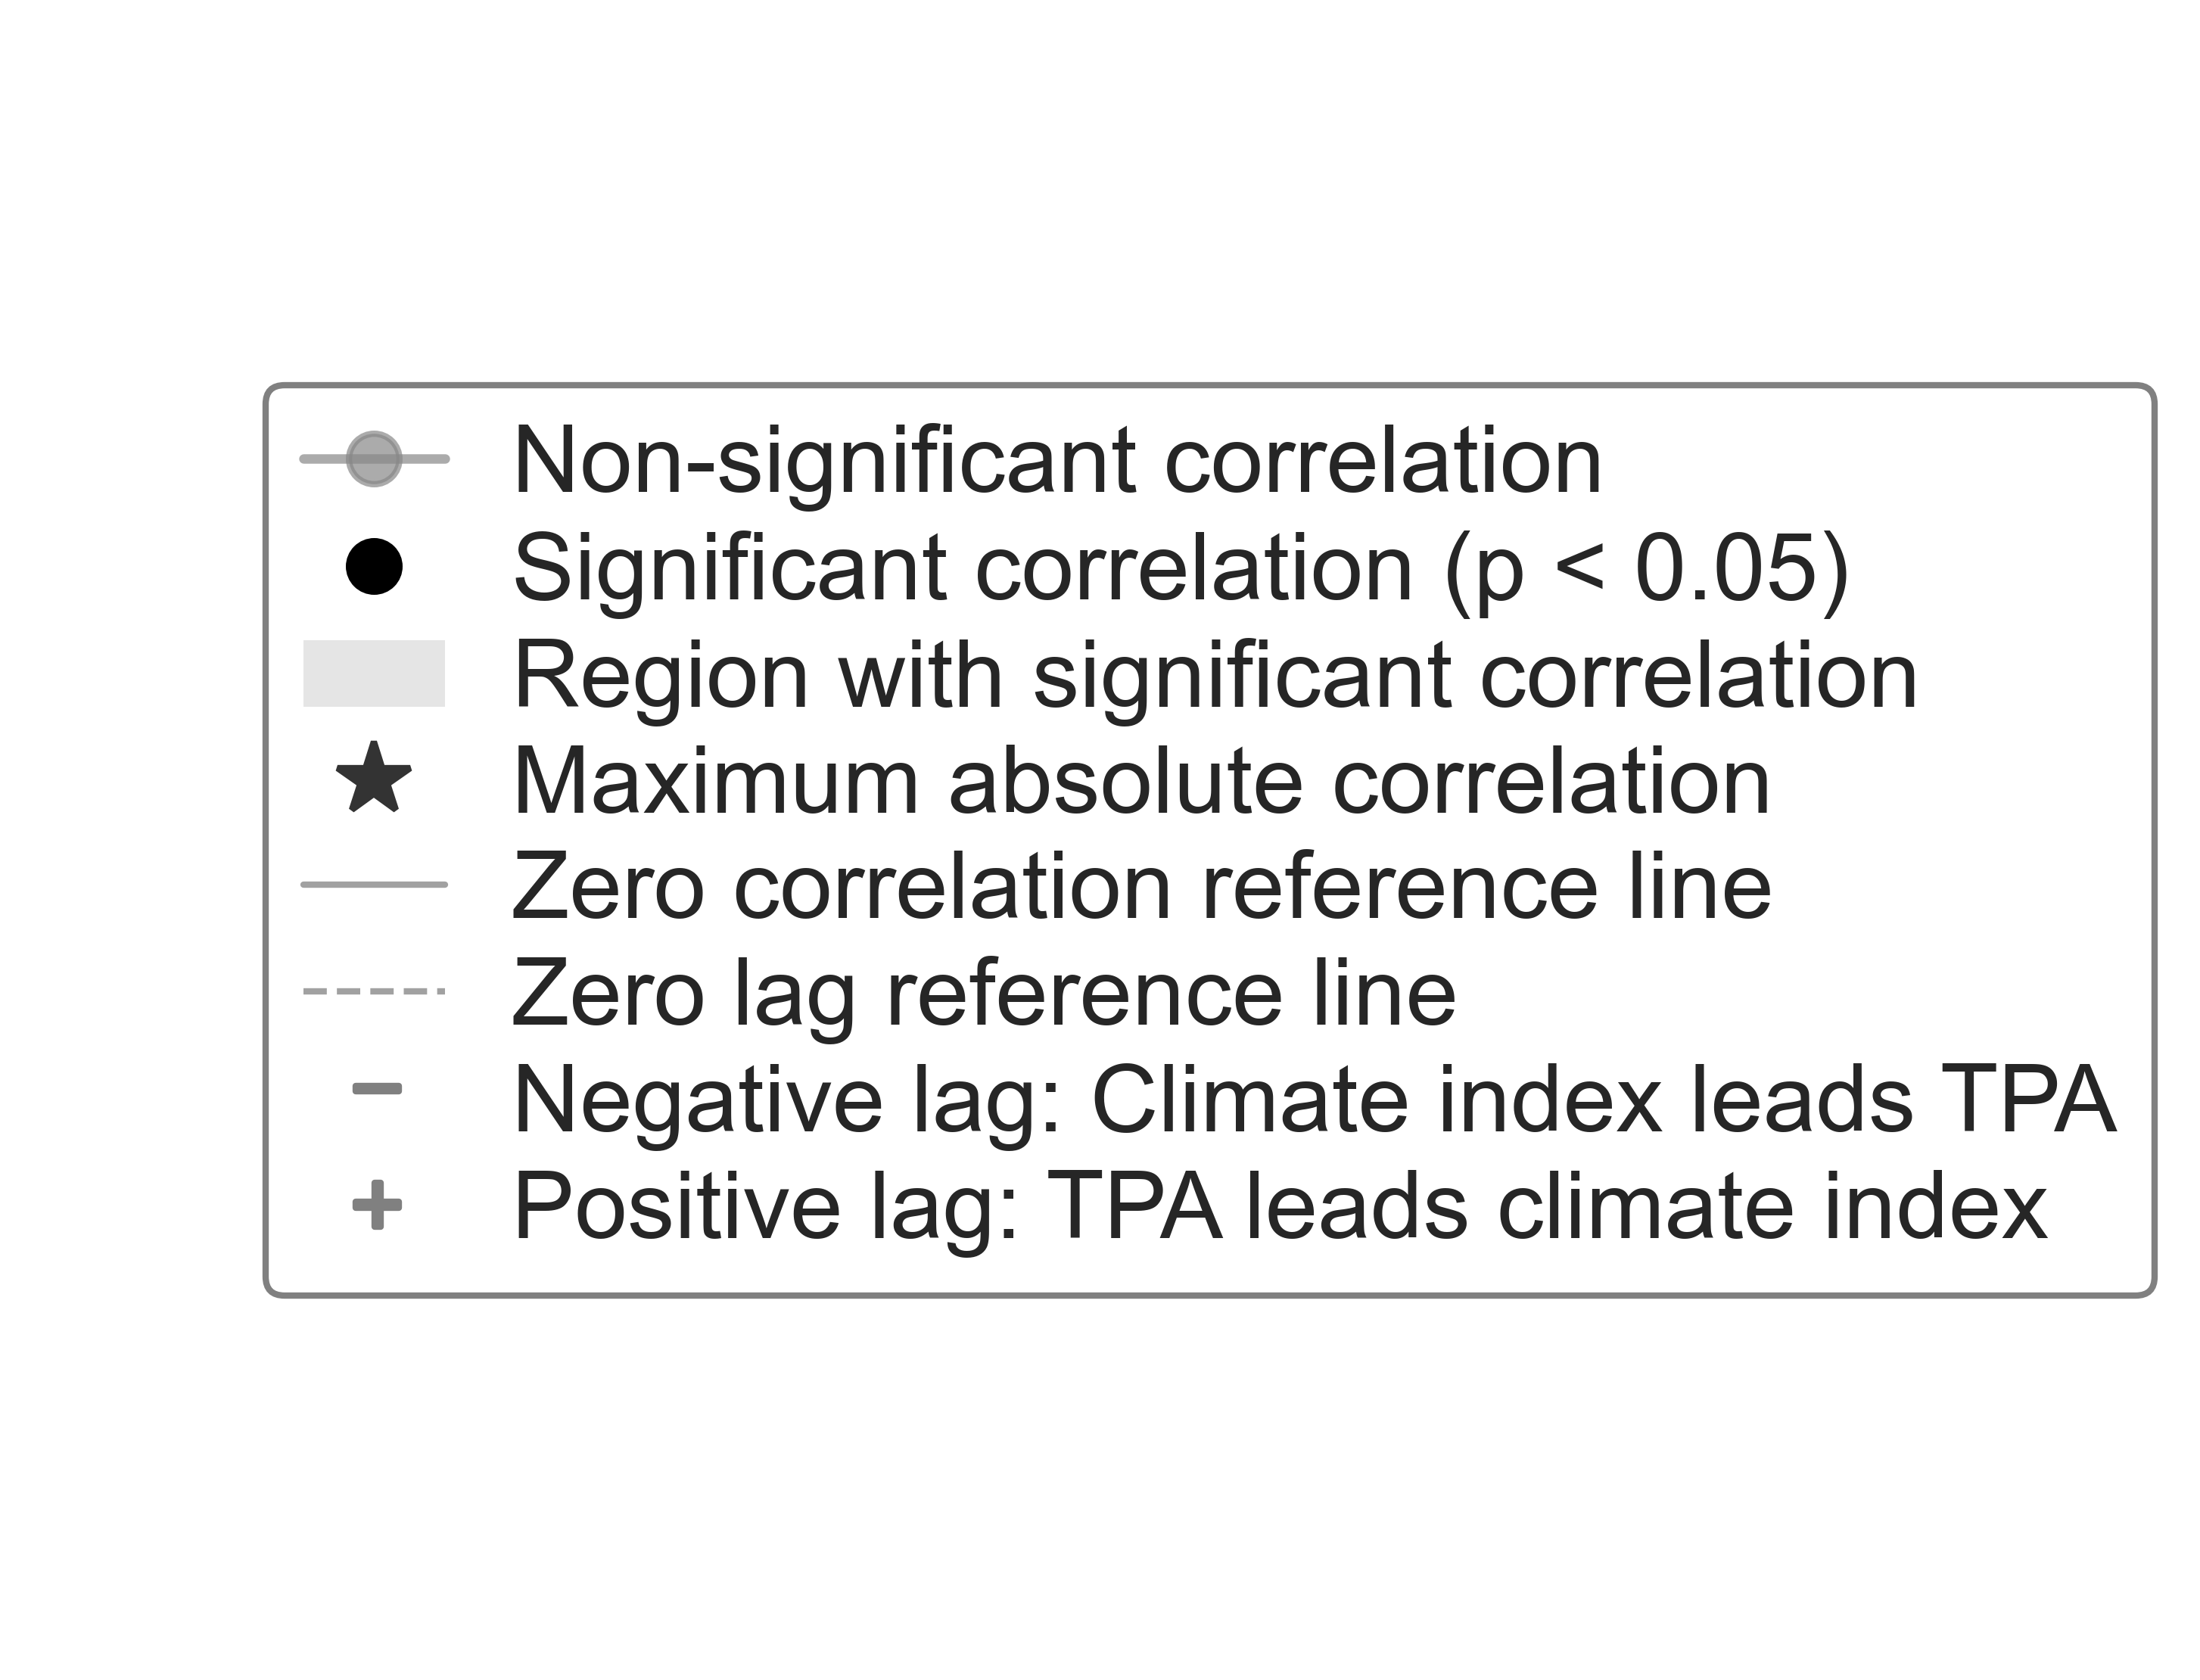

In [143]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os

# Define the same colors used in the correlation plots
colors = {
    'non_significant': '#888888',  # Medium gray for non-significant points
    'significant': '#000000',      # Black for significant points
    'highlight': '#333333',        # Dark gray for highlight points
    'shade_area': '#999999',       # Medium gray for shaded areas
    'zero_line': '#444444',        # Darker gray for zero lines
}

# Create a directory for figures if it doesn't exist
save_dir = r"figures/delay_corr"
os.makedirs(save_dir, exist_ok=True)

# Create a figure with minimal margins
fig = plt.figure(figsize=(3.8, 3.5), dpi=600)
ax = fig.add_subplot(111)

# Remove all axes elements and set tight boundaries
ax.axis('off')
ax.set_position([0, 0, 1, 1])  # Make the axis cover the entire figure

# Create legend handles
legend_elements = [
    mlines.Line2D([0], [0], color=colors['non_significant'], marker='o', 
                 linestyle='-', markersize=8, linewidth=1.5, alpha=0.7,
                 label='Non-significant correlation'),
                 
    mlines.Line2D([0], [0], color=colors['significant'], marker='o',
                 linestyle='none', markersize=8, 
                 label='Significant correlation (p < 0.05)'),
                 
    mpatches.Patch(facecolor=colors['shade_area'], alpha=0.25, edgecolor='none',
                  label='Region with significant correlation'),
                  
    mlines.Line2D([0], [0], color=colors['highlight'], marker='*',
                 linestyle='none', markersize=12, 
                 label='Maximum absolute correlation'),
                 
    mlines.Line2D([0], [0], color=colors['zero_line'], 
                 linestyle='-', linewidth=1, alpha=0.5,
                 label='Zero correlation reference line'),
                 
    mlines.Line2D([0], [0], color=colors['zero_line'], 
                 linestyle='--', linewidth=1, alpha=0.5,
                 label='Zero lag reference line'),
                 
    # Add the lag explanation with + and - as actual visible markers
    mlines.Line2D([0], [0], color='grey', marker='$-$', markersize=8, linestyle='none',
                 label='Negative lag: Climate index leads TPA'),
                 
    mlines.Line2D([0], [0], color='grey', marker='$+$', markersize=8, linestyle='none',
                 label='Positive lag: TPA leads climate index')
]

# Create the legend positioned on the left side
legend = ax.legend(handles=legend_elements, 
                  loc='center left',
                  fontsize=15, 
                  frameon=True, 
                  framealpha=1.0, 
                  edgecolor='gray',
                  handletextpad=0.7,
                  borderpad=0.4,
                  labelspacing=0.2,
                  bbox_to_anchor=(0.1, 0.5),
                  bbox_transform=fig.transFigure,
                  handlelength=1.5)

# Save the figure with minimal padding
plt.savefig(os.path.join(save_dir, 'lag_correlation_legend.png'), 
           dpi=600, 
           bbox_inches='tight',
           pad_inches=0.02)

plt.show()

# Different Test

### Stationarity test

In [63]:
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def check_stationarity(df):
    """
    Performs Augmented Dickey-Fuller test on each column in a DataFrame
    to determine if the time series are stationary.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataframe containing time series data with datetime index
    
    Returns:
    --------
    dict: Dictionary containing ADF test results for each column
    """
    print("=== Stationarity Test (Augmented Dickey-Fuller) ===")
    print("H0: Data is non-stationary (has a unit root)")
    print("H1: Data is stationary")
    print("\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001")
    
    # Store results for each column
    results = {}
    
    # Create a DataFrame to display results in a table format
    summary_data = []
    
    for column in df.columns:
        # Drop missing values
        data = df[column].dropna()
        
        # Skip columns with insufficient data
        if len(data) < 8:  # minimum required for ADF test
            print(f"Warning: Skipping {column} - insufficient data points")
            continue
        
        # Run ADF test
        result = adfuller(data)
        
        # Store detailed results
        results[column] = {
            'ADF Statistic': result[0],
            'p-value': result[1],
            'Critical Values': result[4],
            'Stationary': result[1] < 0.05
        }
        
        # Add significance stars
        stars = ""
        if result[1] < 0.001:
            stars = "***"
        elif result[1] < 0.01:
            stars = "**"
        elif result[1] < 0.05:
            stars = "*"
        
        # Add row to summary table
        summary_data.append({
            'Variable': column,
            'ADF Statistic': f"{result[0]:.4f}",
            'p-value': f"{result[1]:.4f}{stars}",
            'Stationary': "Yes" if result[1] < 0.05 else "No"
        })
    
    # Create and display summary table
    summary_df = pd.DataFrame(summary_data)
    print("\nStationarity Test Results:")
    print(summary_df.to_string(index=False))
    
    # Plot original series and rolling statistics for visual inspection
    print("\nGenerating visual stationarity assessment plots...")

stationarity_results = check_stationarity(monthly_df)

=== Stationarity Test (Augmented Dickey-Fuller) ===
H0: Data is non-stationary (has a unit root)
H1: Data is stationary

Significance levels: * p<0.05, ** p<0.01, *** p<0.001

Stationarity Test Results:
             Variable ADF Statistic   p-value Stationary
                  AMO       -2.5490    0.1040         No
                   EA      -13.7578 0.0000***        Yes
                 ENSO       -7.1906 0.0000***        Yes
                  NAO      -11.8212 0.0000***        Yes
                  PDO       -6.4904 0.0000***        Yes
                SCAND      -17.6216 0.0000***        Yes
pos_total_per_anomaly      -24.3929 0.0000***        Yes
neg_total_per_anomaly      -16.7744 0.0000***        Yes

Generating visual stationarity assessment plots...


### Seasonality

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import f_oneway
import calendar
import warnings
warnings.filterwarnings('ignore')

def check_seasonality(df, period=12, test_only=True):
    """
    Checks for seasonality in time series data using both statistical tests
    and seasonal decomposition (without plotting).
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing time series data with datetime index
    period : int, default=12
        The seasonal period to test for (12 for monthly data)
    test_only : bool, default=True
        If True, only perform statistical tests without decomposition
        
    Returns:
    --------
    dict: Dictionary containing seasonality test results
    """
    print("\n=== Seasonality Analysis ===")
    
    # Check if we have enough data points
    if len(df) < 2 * period:
        print(f"Warning: Not enough data points for reliable seasonality analysis. "
              f"Have {len(df)}, but need at least {2 * period} for period={period}")
        min_periods = min(period, len(df) // 2)
        if min_periods >= 2:
            print(f"Proceeding with reduced period={min_periods} for basic analysis")
            period = min_periods
        else:
            print("Cannot perform seasonality analysis with available data")
            return {}
    
    results = {}
    summary_rows = []
    
    # Loop through each column
    for column in df.columns:
        print(f"\nAnalyzing seasonality for: {column}")
        
        # Get series without NaN values
        series = df[column].dropna()
        if len(series) < period:
            print(f"  Insufficient data for {column}, skipping")
            continue
        
        try:
            # 1. Extract month/season information
            if hasattr(series.index, 'month'):
                series_with_month = pd.DataFrame({
                    'value': series.values,
                    'month': series.index.month
                })
                
                # Group by month
                monthly_groups = [series_with_month[series_with_month['month'] == m]['value'].values 
                                 for m in range(1, period+1) if len(series_with_month[series_with_month['month'] == m]) > 0]
                
                # Only proceed if we have data for multiple months
                if len(monthly_groups) > 1 and all(len(g) > 0 for g in monthly_groups):
                    # One-way ANOVA test for seasonality
                    anova_result = f_oneway(*monthly_groups)
                    
                    # Monthly means for reporting
                    monthly_means = series_with_month.groupby('month')['value'].mean()
                    highest_month = monthly_means.idxmax()
                    lowest_month = monthly_means.idxmin()
                    max_diff = monthly_means.max() - monthly_means.min()
                    
                    # Determine if seasonality is significant
                    is_seasonal = anova_result.pvalue < 0.05
                    
                    # Store test results
                    results[column] = {
                        'f_statistic': anova_result.statistic,
                        'p_value': anova_result.pvalue,
                        'is_seasonal': is_seasonal,
                        'highest_month': calendar.month_abbr[highest_month],
                        'lowest_month': calendar.month_abbr[lowest_month],
                        'max_difference': max_diff,
                        'monthly_means': monthly_means.to_dict()
                    }
                    
                    # Add to summary table
                    summary_rows.append({
                        'Variable': column,
                        'F-statistic': f"{anova_result.statistic:.4f}",
                        'p-value': f"{anova_result.pvalue:.4f}",
                        'Is Seasonal': "Yes" if is_seasonal else "No",
                        'Highest Month': calendar.month_abbr[highest_month],
                        'Lowest Month': calendar.month_abbr[lowest_month],
                        'Max Difference': f"{max_diff:.4f}"
                    })
                    
                    print(f"  ANOVA F-statistic: {anova_result.statistic:.4f}")
                    print(f"  ANOVA p-value: {anova_result.pvalue:.4f}")
                    print(f"  Seasonality: {'Present' if is_seasonal else 'Not detected'}")
                    
                    if is_seasonal:
                        print(f"  Highest in: {calendar.month_name[highest_month]}")
                        print(f"  Lowest in: {calendar.month_name[lowest_month]}")
                
                else:
                    print(f"  Not enough monthly data for {column}")
                    results[column] = {'error': 'Insufficient monthly data'}
            
            else:
                print(f"  Index does not contain month information for {column}")
                results[column] = {'error': 'No month information in index'}
            
            # 2. Perform seasonal decomposition if requested
            if not test_only and len(series) >= 2 * period:
                try:
                    # Calculate decomposition (without plotting)
                    decomposition = seasonal_decompose(series, model='additive', period=period)
                    
                    # Calculate strength of seasonality
                    seasonal_strength = 1.0 - (np.var(decomposition.resid.dropna()) / 
                                             np.var(decomposition.seasonal.dropna() + decomposition.resid.dropna()))
                    
                    # Add decomposition results
                    results[column].update({
                        'decomposition': {
                            'seasonal_strength': seasonal_strength,
                            'trend_present': np.var(decomposition.trend.dropna()) > 0.1 * np.var(series)
                        }
                    })
                    
                    print(f"  Seasonal strength: {seasonal_strength:.4f}")
                    print(f"  Trend component: {'Present' if results[column]['decomposition']['trend_present'] else 'Weak/Absent'}")
                    
                except Exception as e:
                    print(f"  Error in seasonal decomposition: {str(e)}")
            
        except Exception as e:
            print(f"  Error analyzing {column}: {str(e)}")
            results[column] = {'error': str(e)}
    
    # Display summary table
    if summary_rows:
        summary_df = pd.DataFrame(summary_rows)
        print("\nSeasonality Test Results:")
        print(summary_df.to_string(index=False))
        
        # Overall summary
        seasonal_vars = [row['Variable'] for row in summary_rows if row['Is Seasonal'] == "Yes"]
        if seasonal_vars:
            print(f"\nVariables with significant seasonality: {', '.join(seasonal_vars)}")
            print("For correlation analysis with seasonal data:")
            print("1. Consider using seasonally adjusted data")
            print("2. Alternatively, include seasonal dummies in your analysis")
            print("3. Be cautious about spurious correlations due to common seasonal patterns")
        else:
            print("\nNo significant seasonality detected in any variable.")
    
    return results

# To use:
seasonality_results = check_seasonality(monthly_df)


=== Seasonality Analysis ===

Analyzing seasonality for: AMO
  ANOVA F-statistic: 0.3609
  ANOVA p-value: 0.9704
  Seasonality: Not detected

Analyzing seasonality for: EA
  ANOVA F-statistic: 1.5715
  ANOVA p-value: 0.1020
  Seasonality: Not detected

Analyzing seasonality for: ENSO
  ANOVA F-statistic: 0.0526
  ANOVA p-value: 1.0000
  Seasonality: Not detected

Analyzing seasonality for: NAO
  ANOVA F-statistic: 3.1175
  ANOVA p-value: 0.0004
  Seasonality: Present
  Highest in: October
  Lowest in: February

Analyzing seasonality for: PDO
  ANOVA F-statistic: 0.3138
  ANOVA p-value: 0.9831
  Seasonality: Not detected

Analyzing seasonality for: SCAND
  ANOVA F-statistic: 1.1321
  ANOVA p-value: 0.3323
  Seasonality: Not detected

Analyzing seasonality for: pos_total_per_anomaly
  ANOVA F-statistic: 0.0255
  ANOVA p-value: 1.0000
  Seasonality: Not detected

Analyzing seasonality for: neg_total_per_anomaly
  ANOVA F-statistic: 0.0332
  ANOVA p-value: 1.0000
  Seasonality: Not detect